In [21]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
%matplotlib inline

import sys
sys.path.append('/Users/ttshimiz/Github/bat-agn-sed-fitting/')
import plotting as bat_plot
import pickle
import predict_22Ghz_flux as p2f

# Set some plotting parameters
sn.set(context='notebook', color_codes=True, style='ticks')
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'stixsans'

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [3]:
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_v2.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)

# Get rid of the galaxies that are radio-loud and/or have bad fits
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_info = bat_info.drop(bad_sources)

In [78]:
# Upload the predicted and observed 22 GHz fluxes
vla22_predict = pd.read_csv('predicted_22GHz_fluxes.csv', index_col=0)
obs22 = pd.read_table('obs_fluxes.dat', delim_whitespace=True, index_col=0, header=None,
                      names=['core_flux', 'extended_flux'])

In [13]:
# Upload the BAT fluxes for Herschel and WISE
herschel_data = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_herschel.csv', index_col=0,
                            na_values=0)
wise_data = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_wise.csv', index_col=0,
                        usecols=[0, 1, 2, 4, 5, 7, 8, 10, 11], na_values=0)

sed = herschel_data.join(wise_data[['W3', 'W3_err', 'W4', 'W4_err']])

# SPIRE fluxes that are seriously contaminated by a companion should be upper limits
psw_flag = herschel_data['PSW_flag']
pmw_flag = herschel_data['PMW_flag']
plw_flag = herschel_data['PLW_flag']

sed['PSW_err'][psw_flag == 'AD'] = sed['PSW'][psw_flag == 'AD']
sed['PSW'][psw_flag == 'AD'] = np.nan
sed['PMW_err'][pmw_flag == 'AD'] = sed['PMW'][pmw_flag == 'AD']
sed['PMW'][pmw_flag == 'AD'] = np.nan
sed['PLW_err'][plw_flag == 'AD'] = sed['PLW'][plw_flag == 'AD']
sed['PLW'][plw_flag == 'AD'] = np.nan

filt_use = np.array(['W3', 'W4', 'PACS70', 'PACS160', 'PSW', 'PMW', 'PLW'])
filt_err = np.array([s+'_err' for s in filt_use])
waves = np.array([12., 22., 70., 160., 250., 350., 500.])

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWit

In [65]:
names = np.array(['ARK347', 'NGC3516', 'IC2637', 'MCG+06-16-028'])

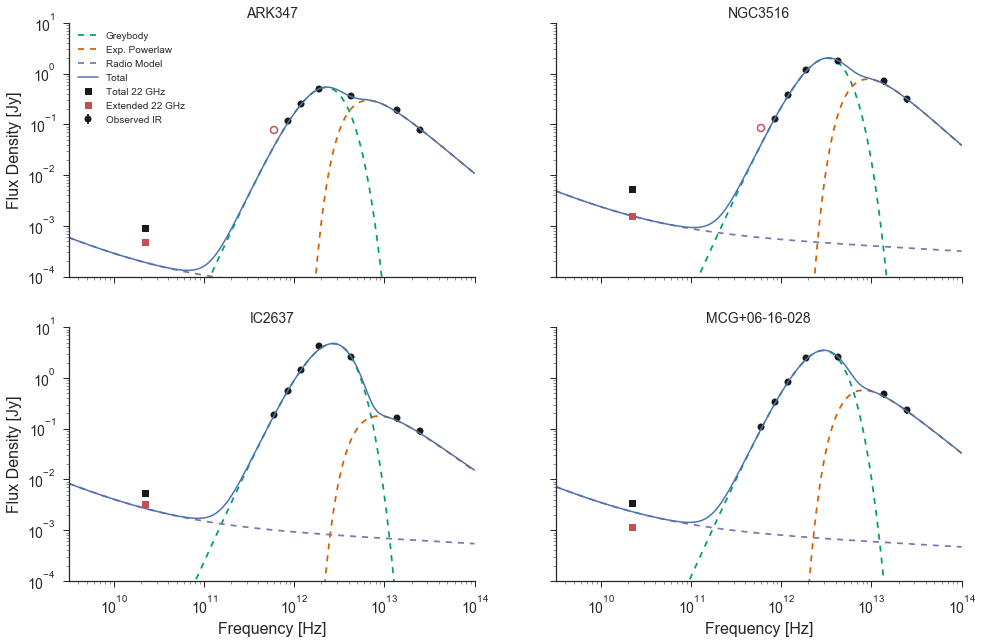

In [85]:
mod_dir = '/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/casey_bayes_results/beta_fixed_2_wturn_gaussianPrior/pickles/'
fig = plt.figure(figsize=(16,10))

alpha = 0.1
gamma = 0.8
reload(p2f)
for k in range(4):
    name = names[k]
    ax = fig.add_subplot(2,2,k+1)
    f = open(mod_dir+name+'_casey_bayes_beta_fixed_2_wturn_gaussianPrior.pickle', 'rb')
    fit_result = pickle.load(f)
    f.close()
    
    bf_mod = fit_result['best_fit_model']
    
    src_sed = sed.loc[name][filt_use]
    src_err = sed.loc[name][filt_err]
    obs_flux = np.array(src_sed, dtype=np.float)
    obs_err = np.array(src_err, dtype=np.float)
    
    zcorr = 1 + bf_mod.redshift
    model_nu = 10**np.arange(9, 14, 0.001)
    model_waves = 3e14/model_nu
    median_model = bf_mod(model_waves/zcorr) * zcorr
    
    ncomps = bf_mod.n_components
    comps = bf_mod.eval_comps(model_waves/zcorr) * zcorr
    comp_colors = sn.color_palette('colorblind', n_colors=ncomps+1)[1:]
    for i in range(ncomps):
        ax.loglog(3e14/model_waves, comps[i, :], ls='--',
                  label=bf_mod.comp_names[i], color=comp_colors[i])
        
    undetected = np.isnan(obs_flux)
    
    if sum(undetected) > 0:
        fluxes = np.hstack([obs_flux[~undetected], obs_err[undetected]])
    else:
        fluxes = obs_flux
    
    ax.errorbar(3e14/waves[~undetected], obs_flux[~undetected],
                yerr=obs_err[~undetected], marker='o', ls='None',
                color='k', label='Observed IR')
    if sum(undetected) > 0:
        ax.plot(3e14/waves[undetected], obs_err[undetected],
                marker='o', mec='r', mfc='None', mew=1.5, ls='None', label='_nolabel')
    
    fir_flux = p2f.calc_fir_flux(bf_mod)
    flux1_4 = p2f.predict_1400mhz_flux(fir_flux)
    total_22, therm_flux_22, nontherm_flux_22 = p2f.predict_22Ghz_flux(flux1_4)
    
    therm_model = therm_flux_22*(model_nu/22e9)**(-alpha)
    sync_model = nontherm_flux_22*(model_nu/22e9)**(-gamma)
    
    ax.loglog(model_nu, therm_model+sync_model, 'm--', label='Radio Model')
    
    ax.loglog(model_nu, therm_model+sync_model+median_model, 'b-', lw=1.5, label='Total')
    #ax.plot(22e9, total_22, 'm*', ms=20)
    ax.plot(22e9, obs22.loc[name, 'extended_flux']/1000., 'ks', label='Total 22 GHz')
    ax.plot(22e9, (obs22.loc[name, 'extended_flux']-obs22.loc[name, 'core_flux'])/1000., 'rs', label='Extended 22 GHz')
    ax.set_ylim(0.0001, 10)
    ax.set_xlim(10**9.5, 10**14)
    ax.set_title(name, fontsize=14)
    if ((k == 0) | (k == 2)):
        ax.set_ylabel('Flux Density [Jy]')
    if (k > 1):
        ax.set_xlabel('Frequency [Hz]')
        
    if (k == 0):
        ax.legend(loc='upper left', fontsize=10)
    
    if (k < 2):
        ax.xaxis.set_ticklabels([])
        
    if ((k == 1) | (k == 3)):
        ax.yaxis.set_ticklabels([])
    sn.despine()

fig.savefig('sed_fits_with_predicted22GHz.eps', bbox_inches='tight')

In [77]:
obs22

,core_flux,extended_flux
2MASXJ04234080+0408017,0.584,6.990
2MASXJ12005792+0648226,0.815,1.230
2MASXJ15462424+6929102,0.268,1.481
2MASXJ20101740+4800214,0.160,0.251
ARK347,0.417,0.893
CGCG122-055,1.790,2.029
CGCG229-015,0.201,0.405
CGCG420-015,0.827,1.170
CGCG493-002,1.175,1.433
ESO548-G081,0.459,2.600
